In [1]:
# Extract data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read meteorological data
Using Data.gov API

- RH_monthly_mean: "https://data.gov.sg/dataset/relative-humidity-monthly-mean"

- rainfall_monthly_count: "https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days"

- rainfall_monthly_total: "https://data.gov.sg/dataset/rainfall-monthly-total"

- Surface Air Temperature_monthly_mean: "https://data.gov.sg/dataset/surface-air-temperature-monthly-mean"

- Sunshine Duration monthly_mean: "https://data.gov.sg/dataset/sunshine-duration-monthly-mean-daily-duration"

In [2]:
import requests

In [3]:
# Resource ids are obtained from the data.gov.sg website (Data API)
resource_ids = {
    "RH" : '4631174f-9858-463d-8a88-f3cb21588c67',
    "Rainfall_count" : '8b94f596-91fd-4545-bf9e-7a426493b674',
    "Rainfall_total" : '778814b8-1b96-404b-9ac9-68d6c00e637b',
    "SA Temp" : '07654ce7-f97f-49c9-81c6-bd41beba4e96',
    "Sunshine" : '0230819f-1c83-4980-b738-56136d6dc300'
}

# since we want all the data, we set the limit to be the maximum value of a 64-bit integer
limit = 9223372036854775807

data = []
# Meteorological data
for key in resource_ids:
    url = f"https://data.gov.sg/api/action/datastore_search?resource_id={resource_ids[key]}&limit={limit}"
    r = requests.get(url)
    data.append(pd.DataFrame(r.json().get('result').get('records')))

In [4]:
# Merge all the data in the list into one dataframe
meteorological = pd.concat(data, join='inner', axis=1)

# Get all the rows for first column of 'month' (there exists multiple columns with the name 'month')
date_value = meteorological['month'].iloc[:,0]

# Make the date a new column at the start (with the name called 'date')
meteorological.insert(loc=0, column='date', value=date_value)

# Delete the duplicate columns ('month' and '_id')
meteorological.drop(['month', '_id'], axis=1, inplace=True)
display(meteorological)

,date,mean_rh,no_of_rainy_days,total_rainfall,mean_temp,mean_sunshine_hrs
0,1982-01,81.2,10,107.1,25.9,5.6
1,1982-02,79.5,5,27.8,27.1,7.6
2,1982-03,82.3,11,160.8,27.2,5.1
3,1982-04,85.9,14,157,27,4.7
4,1982-05,83.2,10,102.2,28,5.8
...,...,...,...,...,...,...
487,2022-08,77.4,15,141.4,28.1,5.5
488,2022-09,76.9,14,121,27.9,3.8
489,2022-10,78.7,27,279,27.6,3.5
490,2022-11,79.9,26,313.8,27.4,3.8


In [5]:
# Check for missing values
meteorological.isnull().sum()

date                 0
mean_rh              0
no_of_rainy_days     0
total_rainfall       0
mean_temp            0
mean_sunshine_hrs    0
dtype: int64

In [6]:
# Reformat the date column into date object
meteorological['date'] = pd.to_datetime(meteorological['date'])

# Convert all data (except date) to numeric
meteorological.iloc[:,1:] = meteorological.iloc[:,1:].apply(pd.to_numeric)

In [7]:
# Resample the data and reduce its granularity to yearly (so that we can compare with our other data)
meteorological = meteorological.resample('Y', on='date').aggregate({'mean_rh': ['mean', 'median', 'max', 'min'], 'no_of_rainy_days': 'sum', 'total_rainfall': 'sum', 'mean_temp': ['mean', 'median', 'max', 'min'], 'mean_sunshine_hrs': ['mean', 'median', 'max', 'min']})

# Rename the columns based on their aggregation functions
meteorological.columns = ['mean_annual_rh', 'median_annual_rh', 'max_annual_rh', 'min_annual_rh', 'annual_num_of_rainy_days', 'total_annual_precipitation', 'mean_annual_temp', 'median_annual_temp', 'max_annual_temp', 'min_annual_temp', 'mean_annual_sunshine_hrs', 'median_annual_sunshine_hrs', 'max_annual_sunshine_hrs', 'min_annual_sunshine_hrs']

# Reset the index so that the date is a column again
meteorological.reset_index(inplace=True)

# Convert date column to only have year
meteorological['date'] = meteorological['date'].dt.year

# Add a new column total_mean_precipitation which is total_annual_precipitation / num of days in the year
# A leap year is exactly divisible by 4 except for century years (years ending with 00). The century year is a leap year only if it is perfectly divisible by 400.
num_of_days = meteorological['date'].apply(lambda x: 366 if ((x % 4 == 0 and x % 100 != 0) or (x % 400 == 0  and x % 100 == 0)) else 365)
meteorological.insert(loc=7, column='total_mean_precipitation', value=(meteorological['total_annual_precipitation'])/num_of_days)

# Round the data to 2 decimal places
meteorological = meteorological.round(2)
display(meteorological)

,date,mean_annual_rh,median_annual_rh,max_annual_rh,min_annual_rh,annual_num_of_rainy_days,total_annual_precipitation,total_mean_precipitation,mean_annual_temp,median_annual_temp,max_annual_temp,min_annual_temp,mean_annual_sunshine_hrs,median_annual_sunshine_hrs,max_annual_sunshine_hrs,min_annual_sunshine_hrs
0,1982,81.97,81.35,87.7,77.6,130,1581.7,4.33,27.36,27.35,28.4,25.9,5.75,5.60,7.6,3.3
1,1983,82.28,82.85,88.0,76.0,145,1993.7,5.46,27.67,27.85,29.4,25.4,5.62,5.65,9.3,2.7
2,1984,84.62,84.10,86.7,82.5,191,2686.7,7.34,26.77,27.00,27.5,25.5,5.08,5.30,6.4,3.3
3,1985,83.21,83.60,86.2,79.4,181,1483.9,4.07,27.12,27.00,28.2,26.1,5.59,5.55,8.7,4.1
4,1986,82.87,84.00,86.6,77.3,174,2536.1,6.95,27.10,26.90,28.3,25.7,5.52,5.50,7.2,3.9
5,1987,82.87,83.00,86.0,79.0,151,2102.8,5.76,27.38,27.55,28.7,25.5,5.92,5.70,9.2,4.0
6,1988,83.84,84.15,86.8,81.1,173,2598.6,7.10,27.23,27.20,28.4,26.2,5.38,5.50,6.7,3.7
7,1989,84.35,84.25,87.6,78.3,173,2463.2,6.75,26.92,26.95,27.7,26.3,5.53,5.50,6.7,4.5
8,1990,82.21,82.50,86.0,77.6,142,1523.8,4.17,27.59,27.55,28.6,26.2,6.20,5.90,8.9,4.6
9,1991,83.13,82.30,90.7,78.7,146,1877.0,5.14,27.43,27.60,28.6,25.6,5.38,5.45,7.1,3.0


### Reading Pollution
Using Singstat API https://tablebuilder.singstat.gov.sg/table/TS/M890641n

In [8]:
# Use the data from the tablebuilder website to get resource id
url = "https://tablebuilder.singstat.gov.sg/api/table/resourceid?keyword=Air Pollution&searchOption=all"

r = requests.get(url)
resource_id = r.json()['Data']['records'][0]['id']

# Get the data from the resource id
url = f"https://tablebuilder.singstat.gov.sg/api/table/tabledata/{resource_id}"
r = requests.get(url)

# Convert the data into a dataframe
data = r.json()['Data']['row']

pollution = pd.DataFrame()
for item in data:
    row = item['columns']
    row_df = pd.DataFrame(row)
    row_df = row_df.set_index('key')
    row_df = row_df.rename(columns={'value': item['rowText']})
    pollution = pollution.join(row_df, how='outer')

pollution.reset_index(inplace=True)
pollution.rename(columns={'key': 'year'}, inplace=True)
display(pollution)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
print(pollution.dtypes)

year                                                         object
Sulphur Dioxide (Maximum 24-Hour Mean)                       object
Nitrogen Dioxide (Annual Mean)                               object
Nitrogen Dioxide (Maximum 1-Hour Mean)                       object
Particulate Matter (PM10) (Annual Mean)                      object
Particulate Matter (PM10) (99th Percentile 24-Hour Mean)     object
Particulate Matter (PM2.5) (Annual Mean)                     object
Particulate Matter (PM2.5) (99th Percentile 24-Hour Mean)    object
Carbon Monoxide (Maximum 8-Hour Mean)                        object
Carbon Monoxide (Maximum 1-Hour Mean)                        object
Ozone (Maximum 8-Hour Mean)                                  object
dtype: object


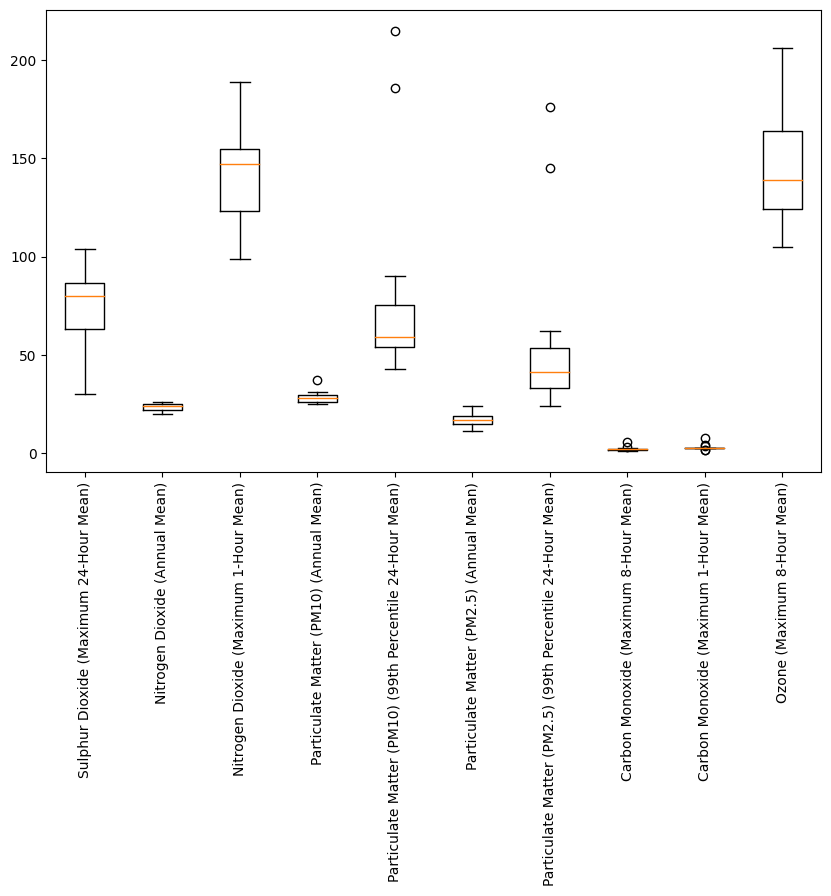

In [ ]:
# Convert type of data into integers
pollution.iloc[:,1:] = pollution.iloc[:,1:].apply(pd.to_numeric)
fig, ax = plt.subplots(figsize=(10, 6))
data = [pollution[col] for col in pollution.columns if col != 'year']
ax.boxplot(data)
ax.set_xticklabels(pollution.columns[1:])
# Horizontal x-axis
ax.tick_params(axis='x', rotation=90)
plt.show()

### Reading Energy Consumption

Using web-scraping: https://main--jolly-kelpie-43bb8d.netlify.app/table.html

*Note this is a statically hosted website. The orignal dataset can be found here: https://www.ema.gov.sg/statistic.aspx?sta_sid=20141211NBOOXgSCZ0no

In [ ]:
from bs4 import BeautifulSoup

url = "https://main--jolly-kelpie-43bb8d.netlify.app/table.html"
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
table = soup.find_all('table')[0] 
energy_consumption = pd.read_html(str(table))[0]

display(energy_consumption)

,year,sector,energy_products,consumption_ktoe
0,2009,Commerce and Services-related,Coal and Peat,0.0
1,2009,Commerce and Services-related,Crude Oil,0.0
2,2009,Commerce and Services-related,Electricity,1272.6
3,2009,Commerce and Services-related,Natural Gas,72.9
4,2009,Commerce and Services-related,Others,0.0
...,...,...,...,...
355,2020,Transport-related,Crude Oil,0.0
356,2020,Transport-related,Electricity,241.5
357,2020,Transport-related,Natural Gas,2.0
358,2020,Transport-related,Others,0.0


[0        0.0
6        0.0
12       3.0
18       0.0
24       0.0
30       0.0
36       0.0
42       5.9
48       0.0
54       0.0
60       0.0
66       0.0
72       5.7
78       0.0
84       0.0
90       0.0
96       0.0
102     23.0
108      0.0
114      0.0
120      0.0
126      0.0
132    129.0
138      0.0
144      0.0
150      0.0
156      0.0
162    162.2
168      0.0
174      0.0
180      0.0
186      0.0
192    162.9
198      0.0
204      0.0
210      0.0
216      0.0
222    166.8
228      0.0
234      0.0
240      0.0
246      0.0
252    600.5
258      0.0
264      0.0
270      0.0
276      0.0
282    182.5
288      0.0
294      0.0
300      0.0
306      0.0
312    180.9
318      0.0
324      0.0
330      0.0
336      0.0
342    182.7
348      0.0
354      0.0
Name: consumption_ktoe, dtype: float64, 1      0.0
7      0.0
13     0.0
19     0.0
25     0.0
31     0.0
37     0.0
43     0.0
49     0.0
55     0.0
61     0.0
67     0.0
73     0.0
79     0.0
85     0.0
91     0.0
97 

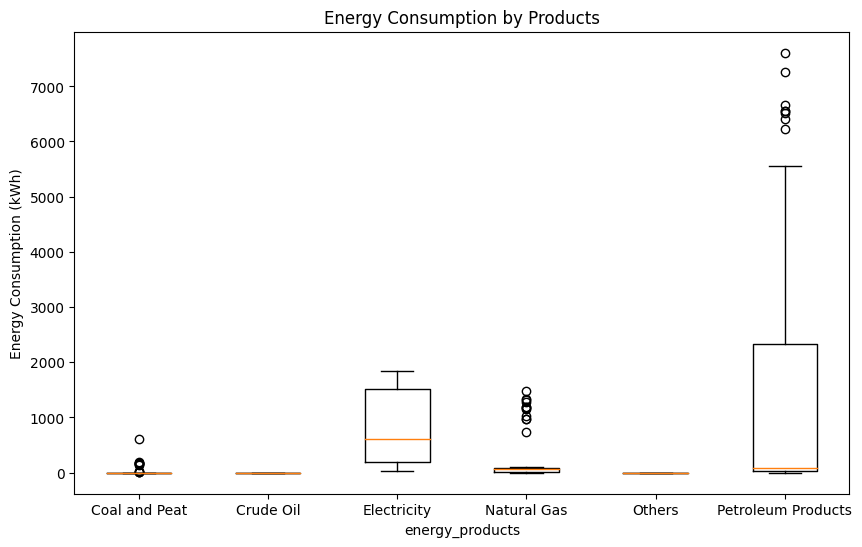

In [ ]:
# Check for outliers in energy consumption
fig, ax = plt.subplots(figsize=(10, 6))
data = [energy_consumption[energy_consumption['energy_products'] == energy_products]['consumption_ktoe'] for energy_products in energy_consumption['energy_products'].unique()]
ax.boxplot(data, labels=energy_consumption['energy_products'].unique())
ax.set_title('Energy Consumption by Products')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('energy_products')
plt.show()

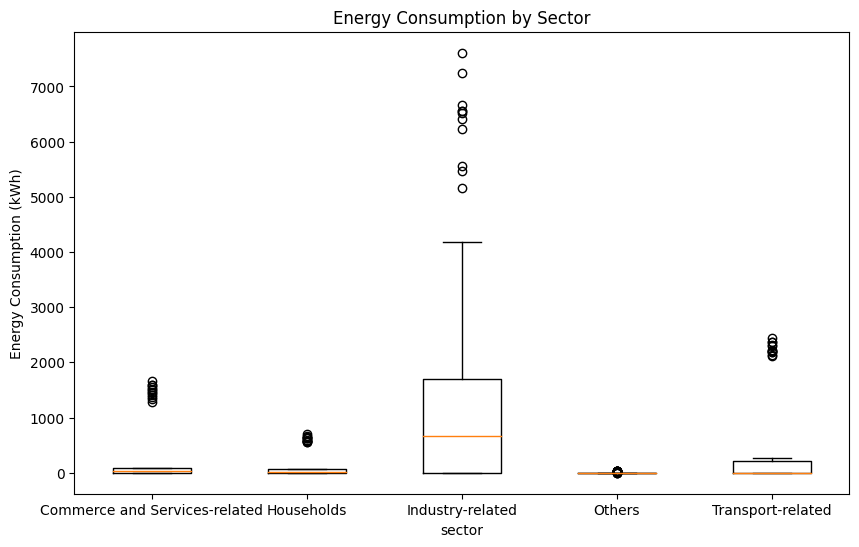

In [ ]:
# Check for outliers by sector
fig, ax = plt.subplots(figsize=(10, 6))
data = [energy_consumption[energy_consumption['sector'] == sector]['consumption_ktoe'] for sector in energy_consumption['sector'].unique()]
ax.boxplot(data, labels=energy_consumption['sector'].unique())
ax.set_title('Energy Consumption by Sector')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('sector')
plt.show()

In [ ]:
# Convert from long to wide format
energy_consumption = energy_consumption.pivot(index='year', columns=['sector', 'energy_products'], values='consumption_ktoe')
energy_consumption.reset_index(inplace=True)
energy_consumption.columns = list(map("_".join, energy_consumption.columns))


In [ ]:
print(energy_consumption.columns)

Index(['year_', 'Commerce and Services-related_Coal and Peat',
       'Commerce and Services-related_Crude Oil',
       'Commerce and Services-related_Electricity',
       'Commerce and Services-related_Natural Gas',
       'Commerce and Services-related_Others',
       'Commerce and Services-related_Petroleum Products',
       'Households_Coal and Peat', 'Households_Crude Oil',
       'Households_Electricity', 'Households_Natural Gas', 'Households_Others',
       'Households_Petroleum Products', 'Industry-related_Coal and Peat',
       'Industry-related_Crude Oil', 'Industry-related_Electricity',
       'Industry-related_Natural Gas', 'Industry-related_Others',
       'Industry-related_Petroleum Products', 'Others_Coal and Peat',
       'Others_Crude Oil', 'Others_Electricity', 'Others_Natural Gas',
       'Others_Others', 'Others_Petroleum Products',
       'Transport-related_Coal and Peat', 'Transport-related_Crude Oil',
       'Transport-related_Electricity', 'Transport-related_Nat

In [ ]:
display(energy_consumption)

,year_,Commerce and Services-related_Coal and Peat,Commerce and Services-related_Crude Oil,Commerce and Services-related_Electricity,Commerce and Services-related_Natural Gas,Commerce and Services-related_Others,Commerce and Services-related_Petroleum Products,Households_Coal and Peat,Households_Crude Oil,Households_Electricity,...,Others_Electricity,Others_Natural Gas,Others_Others,Others_Petroleum Products,Transport-related_Coal and Peat,Transport-related_Crude Oil,Transport-related_Electricity,Transport-related_Natural Gas,Transport-related_Others,Transport-related_Petroleum Products
0,2009,0.0,0.0,1272.6,72.9,0.0,78.5,0.0,0.0,552.9,...,35.6,0.8,0.0,0.0,0.0,0.0,138.2,13.7,0.0,2193.3
1,2010,0.0,0.0,1330.2,78.3,0.0,84.2,0.0,0.0,570.6,...,33.1,0.8,0.0,0.0,0.0,0.0,180.5,20.8,0.0,2219.1
2,2011,0.0,0.0,1365.1,82.4,0.0,68.9,0.0,0.0,557.4,...,29.8,0.8,0.0,0.0,0.0,0.0,191.2,25.9,0.0,2366.9
3,2012,0.0,0.0,1407.2,82.5,0.0,68.3,0.0,0.0,570.0,...,26.1,0.8,0.0,0.0,0.0,0.0,200.2,20.0,0.0,2292.7
4,2013,0.0,0.0,1437.5,89.3,0.0,87.3,0.0,0.0,580.8,...,22.6,0.8,0.0,0.0,0.0,0.0,203.7,18.1,0.0,2133.3
5,2014,0.0,0.0,1465.7,85.3,0.0,78.9,0.0,0.0,595.4,...,20.4,0.8,0.0,0.0,0.0,0.0,209.9,17.4,0.0,2199.8
6,2015,0.0,0.0,1503.1,88.2,0.0,80.0,0.0,0.0,620.9,...,24.0,2.0,0.0,0.0,0.0,0.0,210.2,14.3,0.0,2364.5
7,2016,0.0,0.0,1521.9,92.1,0.0,77.3,0.0,0.0,652.3,...,24.1,2.6,0.0,0.0,0.0,0.0,226.9,11.2,0.0,2436.5
8,2017,0.0,0.0,1553.1,88.5,0.0,75.2,0.0,0.0,626.8,...,23.8,2.4,0.0,0.0,0.0,0.0,238.0,6.9,0.0,2192.0
9,2018,0.0,0.0,1597.8,87.6,0.0,74.4,0.0,0.0,621.8,...,22.2,3.8,0.0,0.0,0.0,0.0,253.6,2.8,0.0,2111.5
